## Satellite Tracking
The recent privatization of space flight have led to the launch of thousands of artificial satellites. These satellites emit electromagnetic radiation across a wide variety of broad- and narrowband frequencies from both intentional and unintentional emissions ([Di Vruno et al. 2023](https://www.aanda.org/articles/aa/pdf/forth/aa46374-23.pdf)). These are begining to negatively impact all ground-based observing through tracks being left in optical images and false signals appearing in radio data.

In an attempt to keep track of satellite emissions, we are going to allocate 4 dishes at the Allen Telescope Array to collect emission data from the regions of the sky which are hte most affected. This will hopefully lead to an exhaustive list of frequencies and locations for all satellites in orbit.

The first step of this is to create a plot with the location of all active satellites in the sky above Hat Creek, the location of the Allen Telescope Array, throughout the course of one day. 

In [1]:
#Import everything you need
import numpy as np
%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook 
from matplotlib.colors import LinearSegmentedColormap
from skyfield import almanac
from skyfield.api import load, wgs84
from skyfield.magnitudelib import planetary_magnitude
from skyfield.api import EarthSatellite
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
import matplotlib
#Makes plots interactive
%autosave 30 
#Makes it to where it autosaves every minute instead of every 2 minutes, just for peace of mind

Autosaving every 30 seconds


In [2]:
#Use skyfield to import the TLE (two-line element) file [gives you all the information on a satellite's location at 
#the epoch, which can be used to find its location at any time] for all active satellites on Norad
active_url = 'https://celestrak.org/norad/elements/active.txt'
active = load.tle_file(active_url, reload = True)
print('Loaded', len(active), 'satellites')

[#################################] 100% active.txt


Loaded 8364 satellites


In [3]:
ts = load.timescale()
t = []
for i in range(24):
    for j in range(0, 60, 10):
            t.append(ts.utc(ts.now().utc[0], ts.now().utc[1], ts.now().utc[2], i, j, 0))

In [4]:
observing_location= EarthLocation.of_site('ATA')#A different way to set our location
observing_time = []
for i in range(len(t)):
    observing_time.append(Time(t[i].utc_datetime()))
aa = AltAz(location=observing_location, obstime=observing_time)

In [5]:
ata = wgs84.latlon(+observing_location.lat.value, observing_location.lon.value)

In [6]:
names = []
for i in range(len(active)):
    names.append(active[i].name)

In [7]:
difference = []
for i in range(len(active)):
    difference.append(active[i] - ata)

In [8]:
topocentric = []
for i in range(len(difference)):
    for j in range(len(t)):
        topocentric.append(difference[i].at(t[j]))

In [9]:
%%time
#takes about 1 minute to run
alt = []
az = []
distance = []
for i in range(len(topocentric)):
    if np.isnan(topocentric[(i)].altaz()[0].degrees) == True:
        alt.append(0)
        az.append(0)
        distance.append(0)
    elif np.isnan(topocentric[(i)].altaz()[0].degrees) == False:
        alt.append(topocentric[i].altaz()[0].degrees)
        az.append(topocentric[i].altaz()[1].degrees)
        distance.append(topocentric[i].altaz()[2].au)

CPU times: user 1min 7s, sys: 999 ms, total: 1min 8s
Wall time: 1min 9s


In [10]:
alt = np.reshape(alt, (len(active), len(t)))
az = np.reshape(az, (len(active), len(t)))
distance = np.reshape(distance, (len(active), len(t)))

To create the plots which show the areas where the most satellites are located, I used a heatmap.

Code for the heatmaps from [here](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html)

In [11]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, shrink = 0.5)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize = 9)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize = 9)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.gca().invert_yaxis()

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)], fontsize = 9)
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

For these plots, we are going to be looking at the sky above the ATA sectioned up 4 different ways -- 9$\times$36 (a 10 degree fov), 18${\times}$72 (a 5 degree fov), 30$\times$120 (a 3 degree fov), and 90$\times$360 (a 1 degree fov). 

First, the 9$\times$36

In [12]:
%%time
qt = []
at = []
for i in range(len(alt)):
    #print(i) #uncomment this if you want to see where it is in its running
    for j in range(len(t)):
        if alt[i][j] > 0:
            for h in range(0, 9):
                if (h*10) <= alt[i][j] < ((h+1)*10):
                    for k in range(0, 36):
                        if (k*10) <= az[i][j] < ((k+1)*10):
                            qt.append((h*36) + k + 1)
                            at.append((h*36) + k + 1)
        if alt[i][j] <= 0:
            qt.append(0)
            at.append(0)
        #if type(altaz_rebinned[i][j]) == int:
         #   qt.append(0)
          #  at.append(0)

CPU times: user 1.2 s, sys: 20.3 ms, total: 1.22 s
Wall time: 1.23 s


In [13]:
qt = np.reshape(qt, (len(active), len(t)))
at = np.reshape(at, (len(active), len(t)))

In [14]:
%%time
#I'm correcting for the geo satellites by setting 
for i in range(len(at)):
    for j in range(len(at[0])-1):
        if at[i][j] == at[i][j+1]:
            qt[i][j+1] = 0

CPU times: user 444 ms, sys: 5.05 ms, total: 449 ms
Wall time: 451 ms


In [15]:
qt = np.reshape(qt, (len(active) * len(t)))
at = np.reshape(at, (len(active) * len(t)))

In [16]:
%%time
s10fix = []
s10f2 = []
for i in range(len(qt)):
    s10fix.append(f's{qt[i]}')
for i in range(len(at)):
    s10f2.append(f's{at[i]}')


CPU times: user 484 ms, sys: 22.2 ms, total: 506 ms
Wall time: 509 ms


In [17]:
%%time
#which section the satellite is in
sections_10f = []
sections_10f2 = []
for i in range(1, 325):
    if s10fix.count(f's{i}') == 0:
        sections_10f.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s10fix.count(f's{i}') != 0:
        sections_10f.append(s10fix.count(f's{i}'))
        
for i in range(1, 325):
    if s10f2.count(f's{i}') == 0:
        sections_10f2.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s10f2.count(f's{i}') != 0:
        sections_10f2.append(s10f2.count(f's{i}'))

CPU times: user 15.7 s, sys: 157 ms, total: 15.9 s
Wall time: 15.9 s


In [18]:
%%time
alt_range10f = []
az_range10f = []

for i in range(0, 9):
    alt_range10f.append(f'{i*10} - {(i+1)*10}')
for i in range(0, 36):
    az_range10f.append(f'{i*10} - {(i + 1)*10}')

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 12.2 µs


In [19]:
sections10f = np.reshape(sections_10f, (9, 36))
sections10f2 = np.reshape(sections_10f2, (9, 36))
#making it to where it's a 2d array to plot on the heatmap

<IPython.core.display.Javascript object>


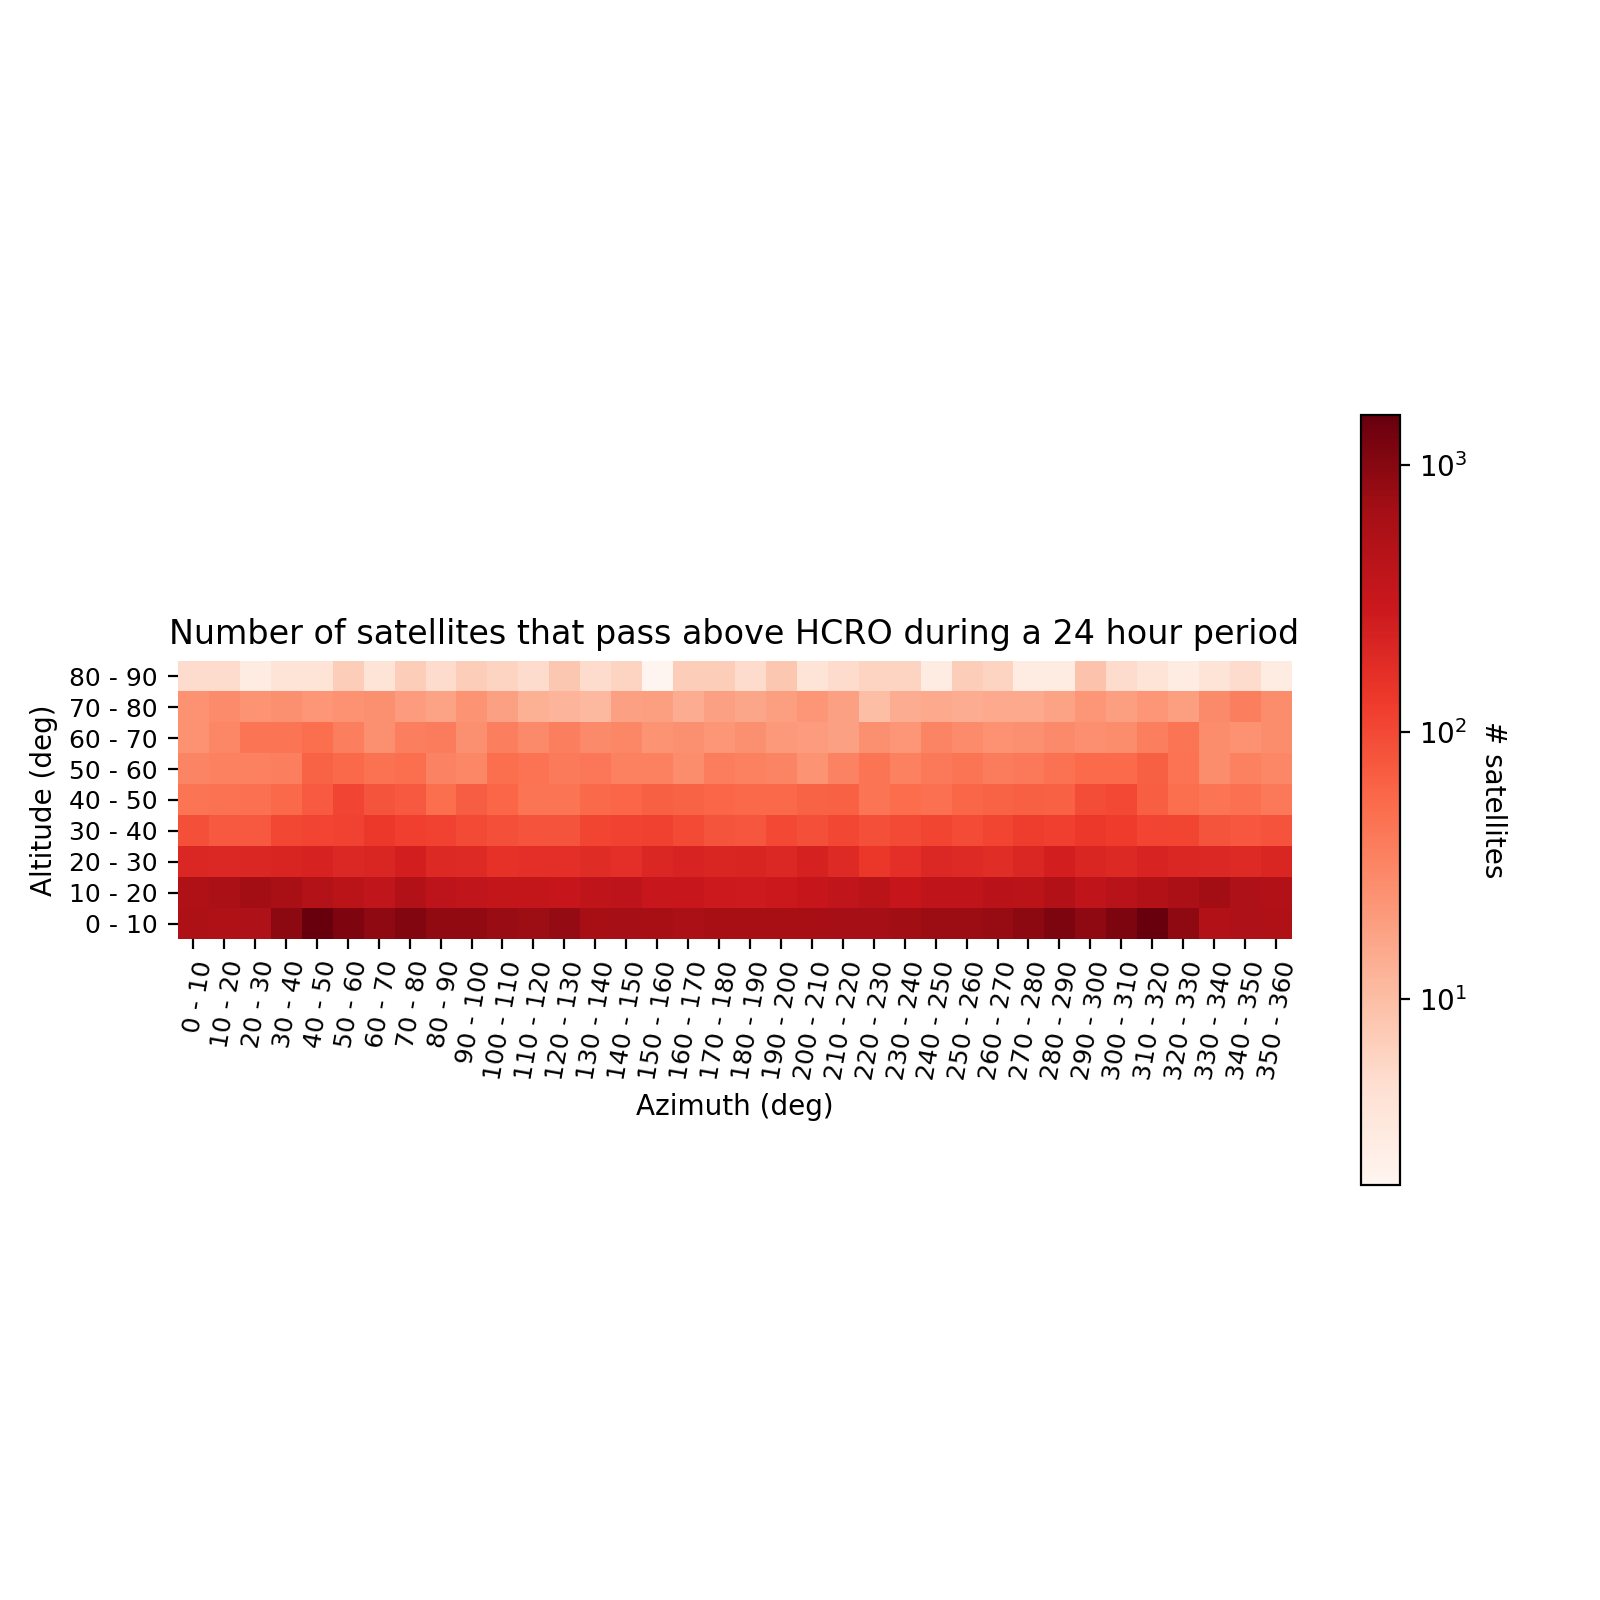

In [20]:
#With correcting for geo satellites
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections10f), alt_range10f, az_range10f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('10deg.jpeg')

<IPython.core.display.Javascript object>


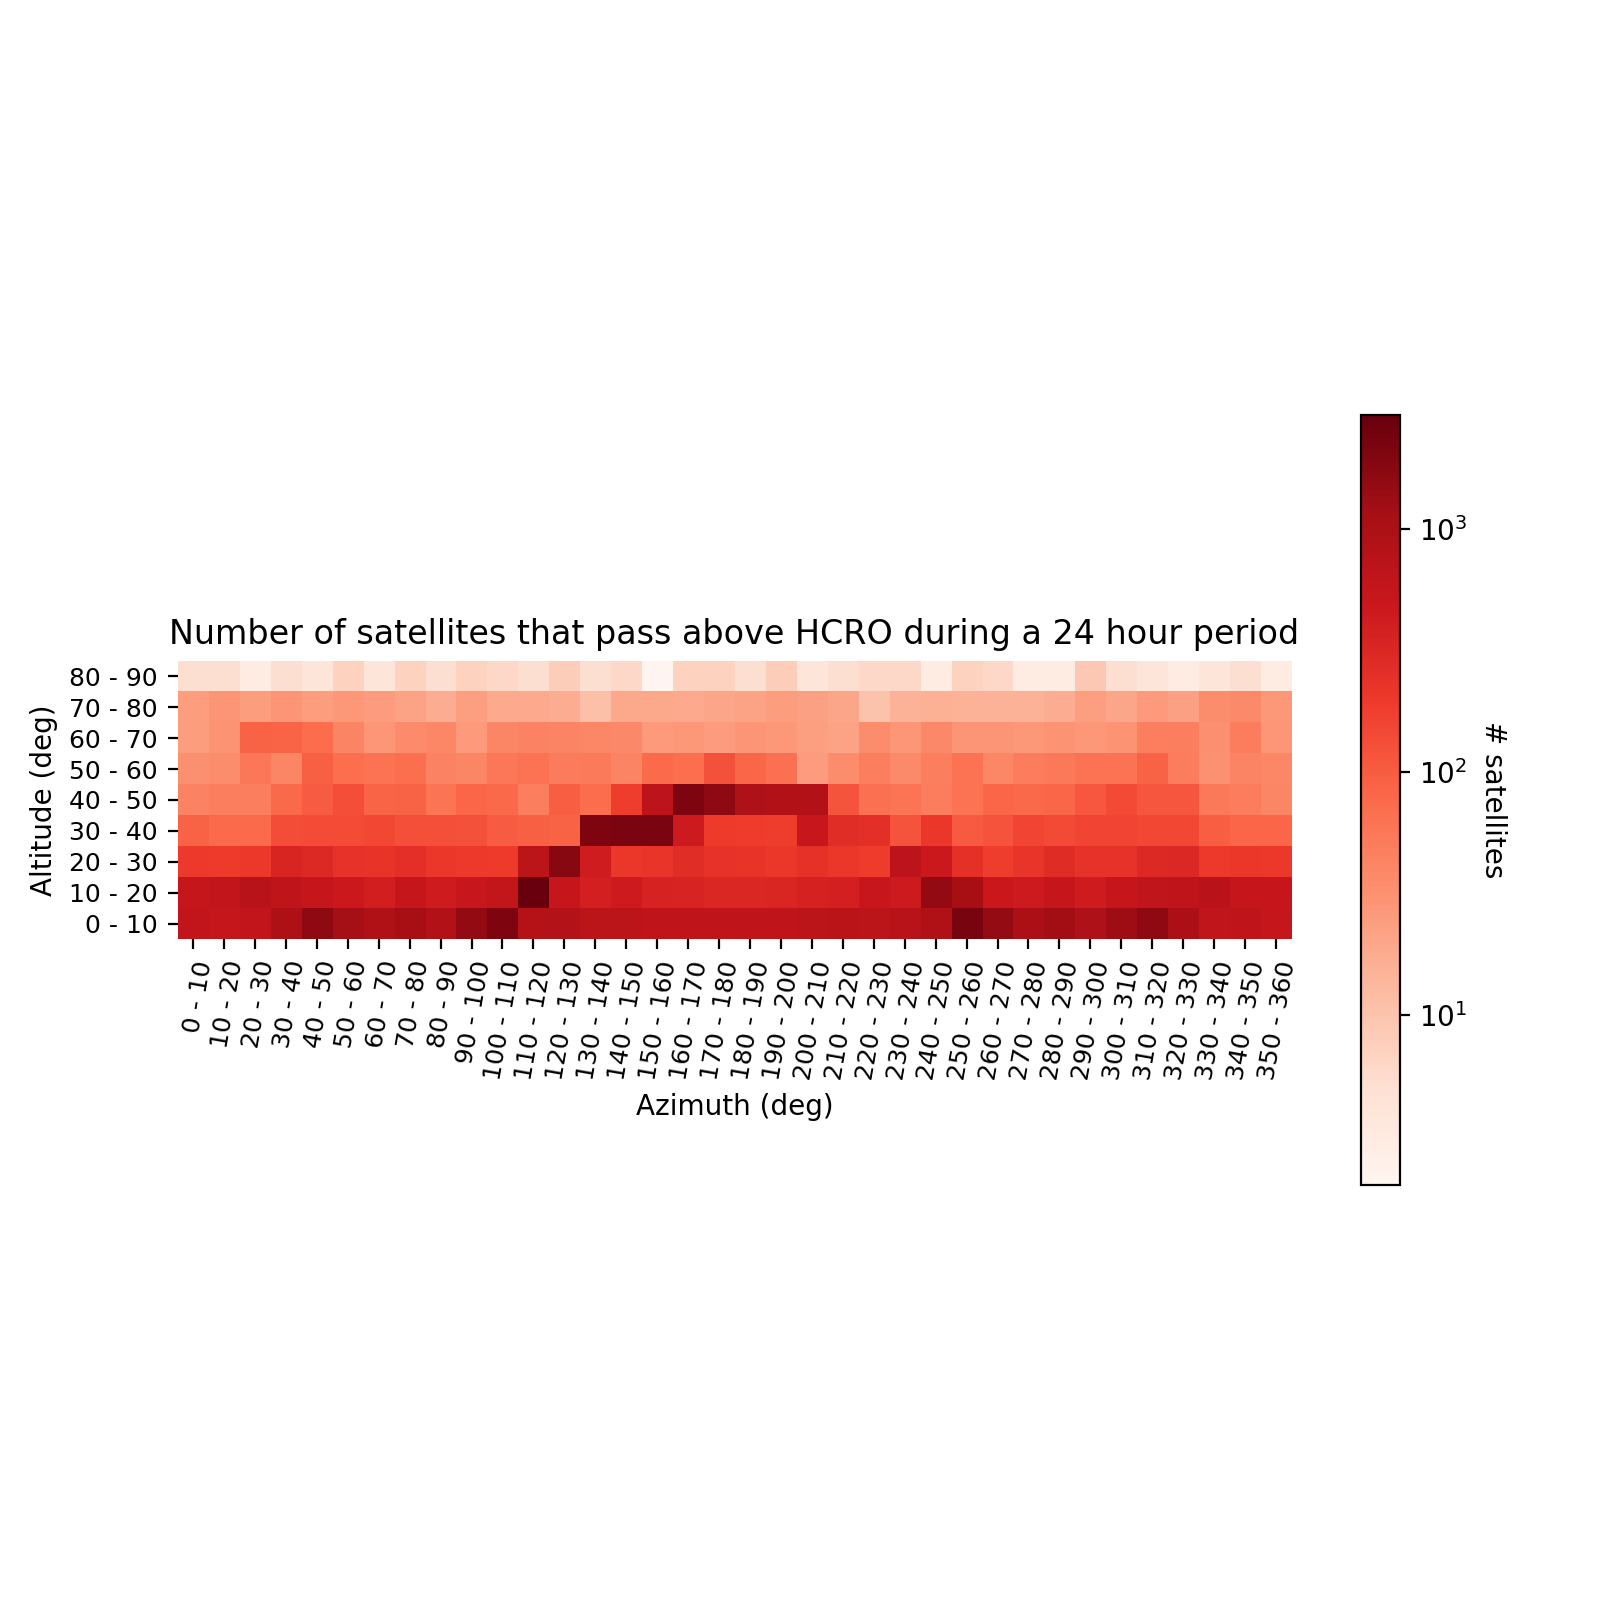

In [21]:
#Without correcting for geo satellites
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections10f2), alt_range10f, az_range10f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('10deg.jpeg')

And then for the $18 \times 72$ grid

In [22]:
%%time
qt5 = []
at5 = []
for i in range(len(alt)):
    #print(i)
    for j in range(len(t)):
        if alt[i][j] > 0:
            for h in range(0, 18):
                if (h*5) <= alt[i][j] < ((h+1)*5):
                    for k in range(0, 72):
                        if (k*5) <= az[i][j] < ((k+1)*5):
                            qt5.append((h*72) + k + 1)
                            at5.append((h*72) + k + 1)
        if alt[i][j] <= 0:
            qt5.append(0)
            at5.append(0)
        #if type(altaz_rebinned[i][j]) == int:
         #   qt.append(0)
          #  at.append(0)

CPU times: user 2.5 s, sys: 38.3 ms, total: 2.54 s
Wall time: 2.1 s


In [23]:
qt5 = np.reshape(qt5, (len(active), len(t)))
at5 = np.reshape(at5, (len(active), len(t)))

In [24]:
for i in range(len(at5)):
    for j in range(len(at5[0])-1):
        if at5[i][j] == at5[i][j+1]:
            qt5[i][j+1] = 0

In [25]:
qt5 = np.reshape(qt5, (len(active) * len(t)))
at5 = np.reshape(at5, (len(active) * len(t)))

In [26]:
%%time
s5q = []
s5a = []
for i in range(len(qt5)):
    s5q.append(f's{qt5[i]}')
for i in range(len(at5)):
    s5a.append(f's{at5[i]}')


CPU times: user 452 ms, sys: 29.8 ms, total: 482 ms
Wall time: 485 ms


In [27]:
%%time
#takes about 1 minute
#which section the satellite is in
sections_5q = []
sections_5a = []
for i in range(1, 1297):
    if s5q.count(f's{i}') == 0:
        sections_5q.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s5q.count(f's{i}') != 0:
        sections_5q.append(s5q.count(f's{i}'))
        
for i in range(1, 1297):
    if s5a.count(f's{i}') == 0:
        sections_5a.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s5a.count(f's{i}') != 0:
        sections_5a.append(s5a.count(f's{i}'))

CPU times: user 1min 3s, sys: 795 ms, total: 1min 3s
Wall time: 1min 4s


In [28]:
%%time
alt_range5f = []
az_range5f = []

for i in range(0,18):
    alt_range5f.append(f'{i*5} - {(i+1)*5}')
for i in range(0, 72):
    az_range5f.append(f'{i*5} - {(i + 1)*5}')

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 19.8 µs


In [29]:
az_range5f_label = []
alt_range5f_label = []
azs5 = []
alts5 = []
for i in range(int(len(az_range5f)/2)):
    azs5.append((i*2)+1)
    az_range5f_label.append(az_range5f[azs5[-1]])
    
for i in range(int(len(alt_range5f)/2)):
    alts5.append((i*2)+1)
    alt_range5f_label.append(alt_range5f[alts5[-1]])

In [30]:
sections5a = np.reshape(sections_5a, (18, 72))
sections5q = np.reshape(sections_5q, (18, 72))
#making it to where it's a 2d array to plot on the heatmap

<IPython.core.display.Javascript object>


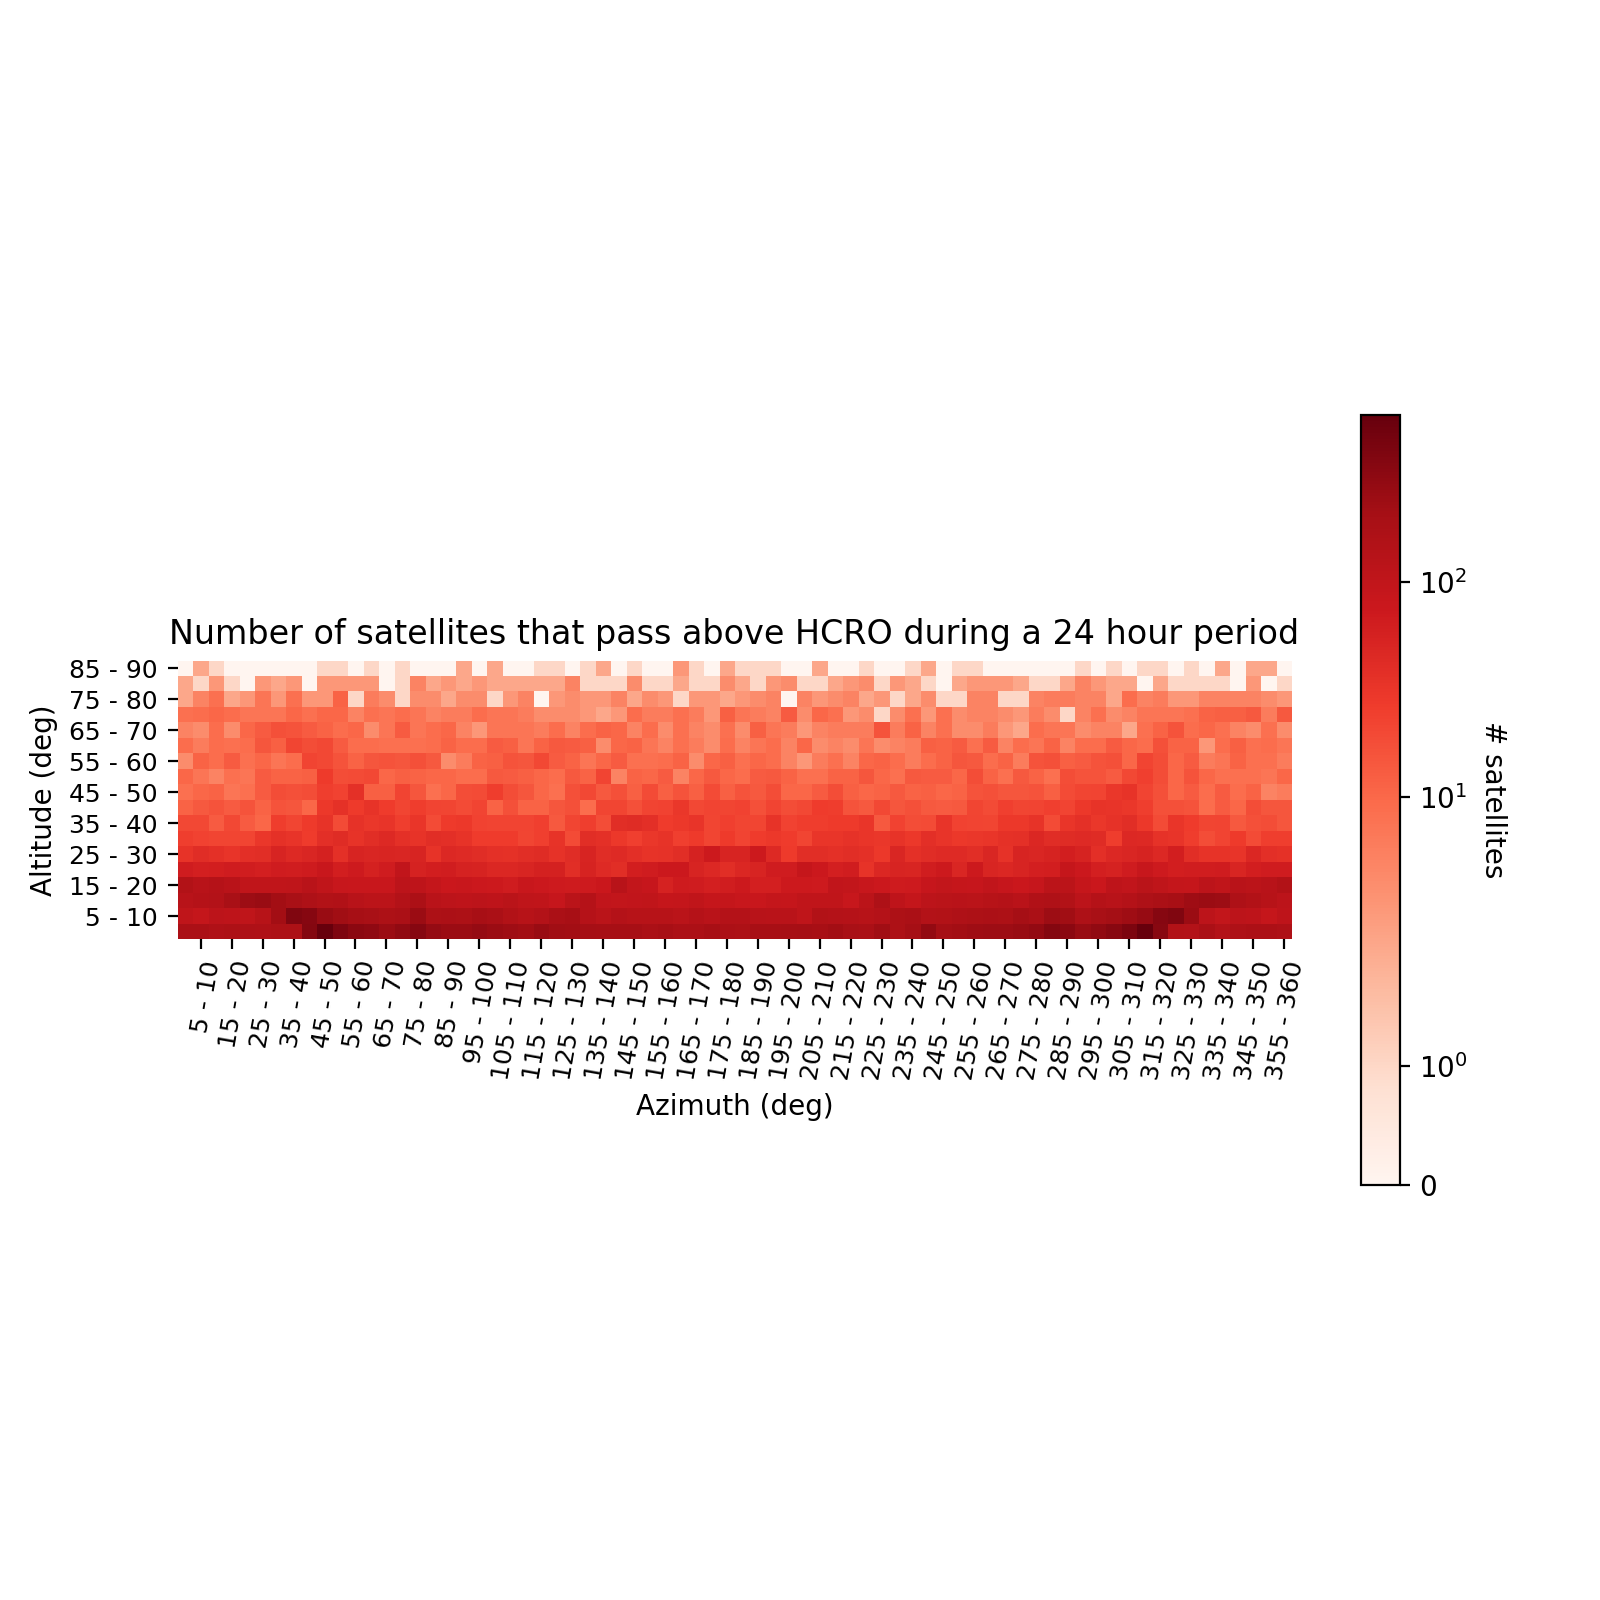

In [31]:
#with correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections5q), alt_range5f, az_range5f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs5, labels=az_range5f_label)
plt.yticks(ticks = alts5, labels = alt_range5f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
plt.savefig('5deg.jpeg')

<IPython.core.display.Javascript object>


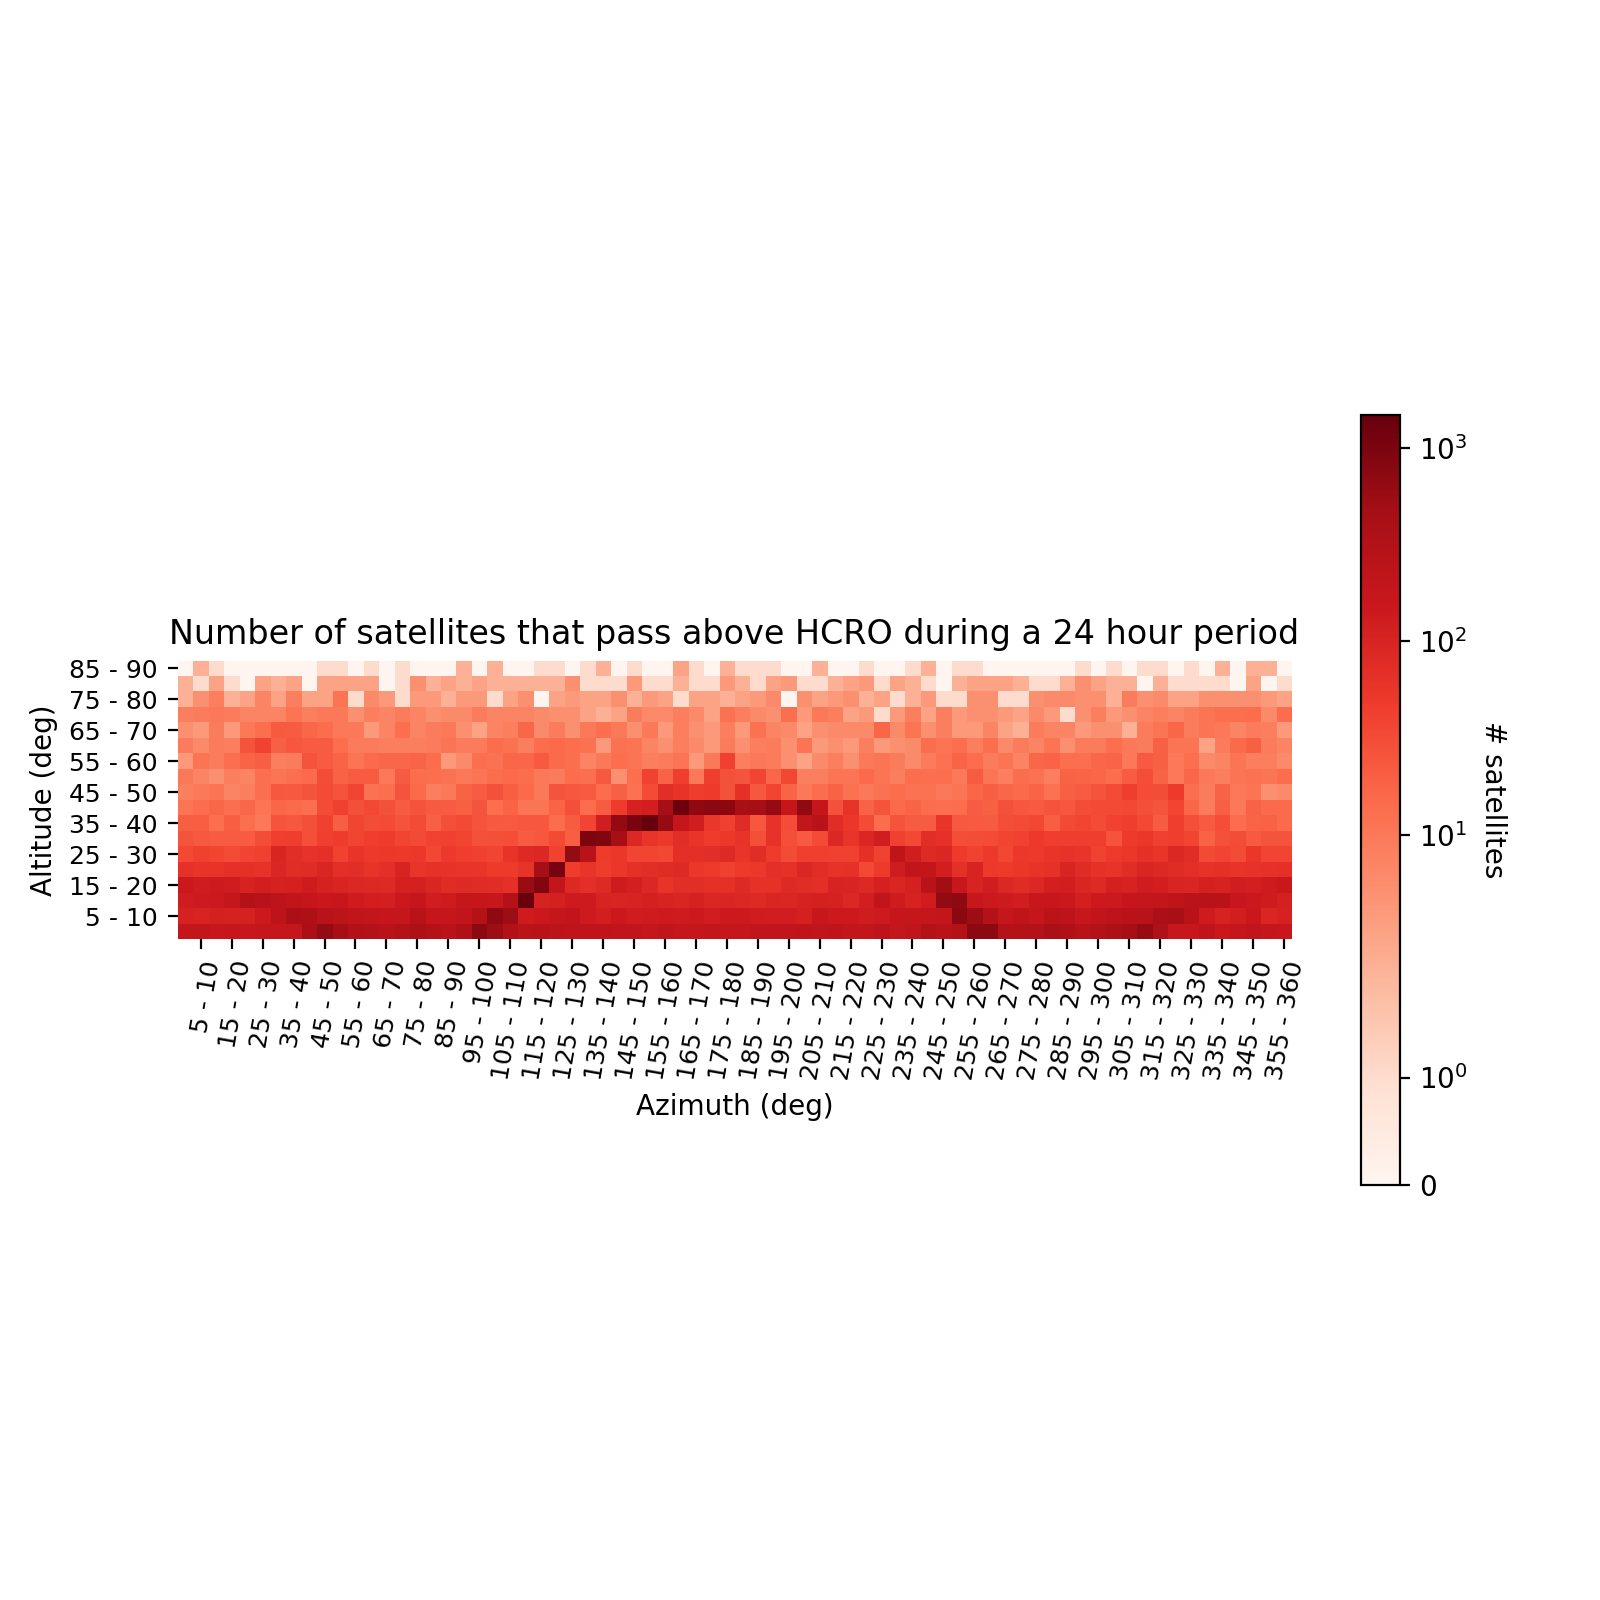

In [32]:
#Without correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections5a), alt_range5f, az_range5f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs5, labels=az_range5f_label)
plt.yticks(ticks = alts5, labels = alt_range5f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('5deg.jpeg')

In [33]:
len(at5)/144

8364.0

<IPython.core.display.Javascript object>


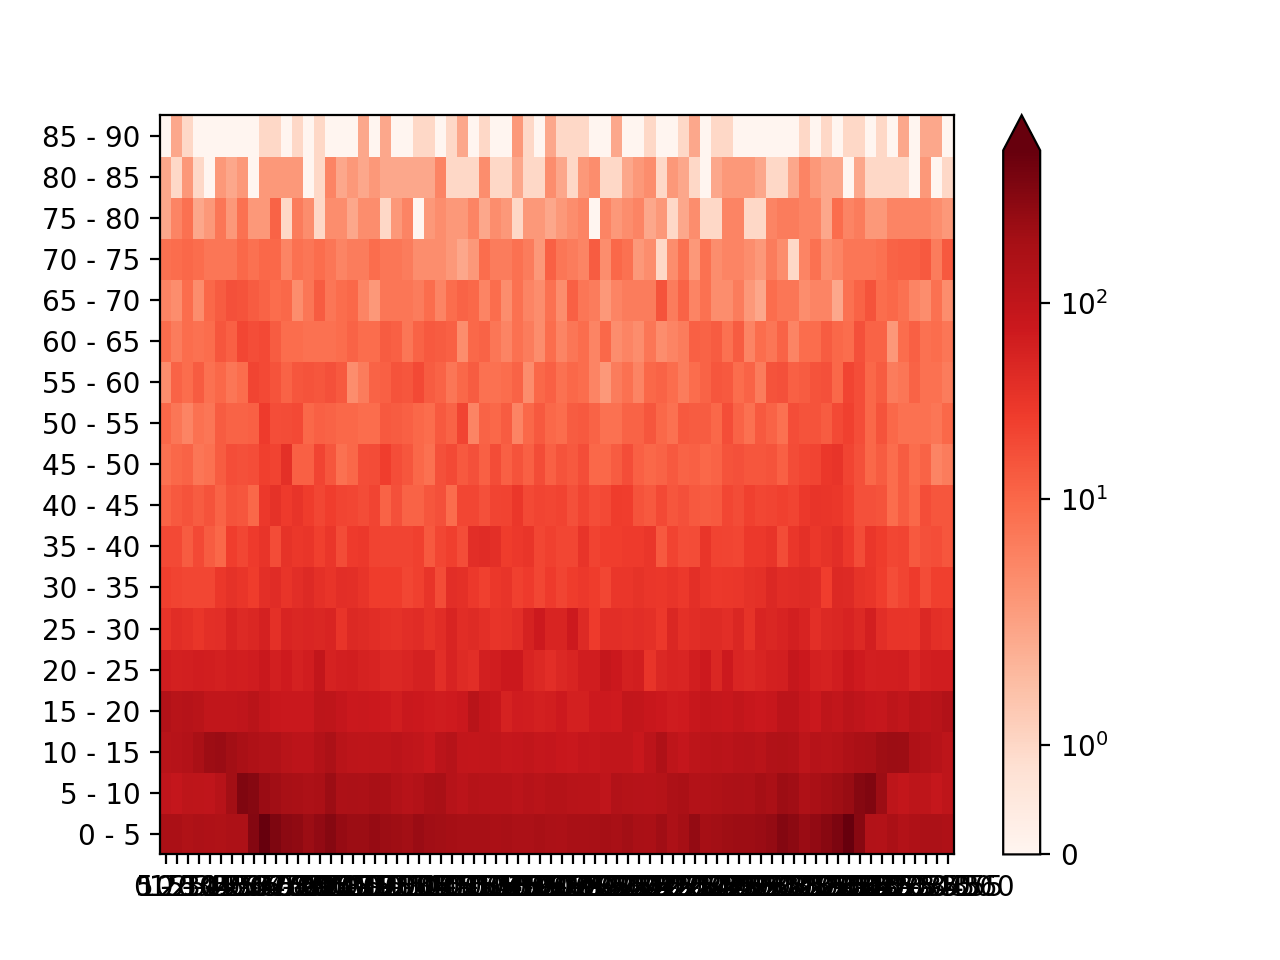

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

X = az_range5f
Y = alt_range5f

# A low hump with a spike coming out of the top right.  Needs to have
# z/colour axis on a log scale, so we see both hump and spike. A linear
# scale only shows the spike.
Z = sections5q

fig, ax = plt.subplots(1, 1)
#fig = plt.figure(figsize = (8, 6))
pcm = ax.pcolor(X, Y, Z, norm = 'symlog',
                   #norm=colors.LogNorm(vmin=1, vmax=Z.max()),
                   cmap='Reds', shading='auto')
fig.colorbar(pcm, ax=ax, extend='max')

#pcm = ax[1].pcolor(X, Y, Z, cmap='PuBu', shading='auto')
#fig.colorbar(pcm, ax=ax[1], extend='max')
plt.show()

And then for the $30 \times 120$ grid

In [35]:
%%time
qt3 = []
at3 = []
for i in range(len(alt)):
    #print(i)
    for j in range(len(t)):
        if alt[i][j] > 0:
            for h in range(0, 30):
                if (h*3) <= alt[i][j] < ((h+1)*3):
                    for k in range(0, 120):
                        if (k*3) <= az[i][j] < ((k+1)*3):
                            qt3.append((h*120) + k + 1)
                            at3.append((h*120) + k + 1)
        if alt[i][j] <= 0:
            qt3.append(0)
            at3.append(0)
        #if type(altaz_rebinned[i][j]) == int:
         #   qt.append(0)
          #  at.append(0)

CPU times: user 3.37 s, sys: 54.9 ms, total: 3.42 s
Wall time: 3.02 s


In [36]:
qt3 = np.reshape(qt3, (len(active), len(t)))
at3 = np.reshape(at3, (len(active), len(t)))

In [37]:
for i in range(len(at3)):
    for j in range(len(at3[0])-1):
        if at3[i][j] == at3[i][j+1]:
            qt3[i][j+1] = 0

In [38]:
qt3 = np.reshape(qt3, (len(active) * len(t)))
at3 = np.reshape(at3, (len(active) * len(t)))

In [39]:
%%time
s3q = []
s3a = []
for i in range(len(qt3)):
    s3q.append(f's{qt3[i]}')
    
for i in range(len(at3)):
    s3a.append(f's{at3[i]}')


CPU times: user 460 ms, sys: 25.7 ms, total: 486 ms
Wall time: 486 ms


In [40]:
%%time
#About 3 minutes
#which section the satellite is in
sections_3a = []
sections_3q = []
for i in range(1, 3601):
    if s3a.count(f's{i}') == 0:
        sections_3a.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s3a.count(f's{i}') != 0:
        sections_3a.append(s3a.count(f's{i}'))
        
for i in range(1, 3601):
    if s3q.count(f's{i}') == 0:
        sections_3q.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s3q.count(f's{i}') != 0:
        sections_3q.append(s3q.count(f's{i}'))

CPU times: user 2min 48s, sys: 2.01 s, total: 2min 50s
Wall time: 2min 52s


In [41]:
%%time
alt_range3f = []
az_range3f = []

for i in range(0,30):
    alt_range3f.append(f'{i*3} - {(i+1)*3}')
for i in range(0, 120):
    az_range3f.append(f'{i*3} - {(i + 1)*3}')

CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 31.9 µs


In [42]:
#Creating the x- and y-axis tick labels for the heatmap
az_range3f_label = []
alt_range3f_label = []
azs3 = []
alts3 = []
for i in range(1, int(len(az_range3f)/5)):
    azs3.append((i*5)-1)
    az_range3f_label.append(az_range3f[azs3[-1]])
    
for i in range(1, int(len(alt_range3f)/5)):
    alts3.append((i*5)-1)
    alt_range3f_label.append(alt_range3f[alts3[-1]])

In [43]:
sections3a = np.reshape(sections_3a, (30, 120))
sections3q = np.reshape(sections_3q, (30, 120))
#making it to where it's a 2d array to plot on the heatmap

<IPython.core.display.Javascript object>


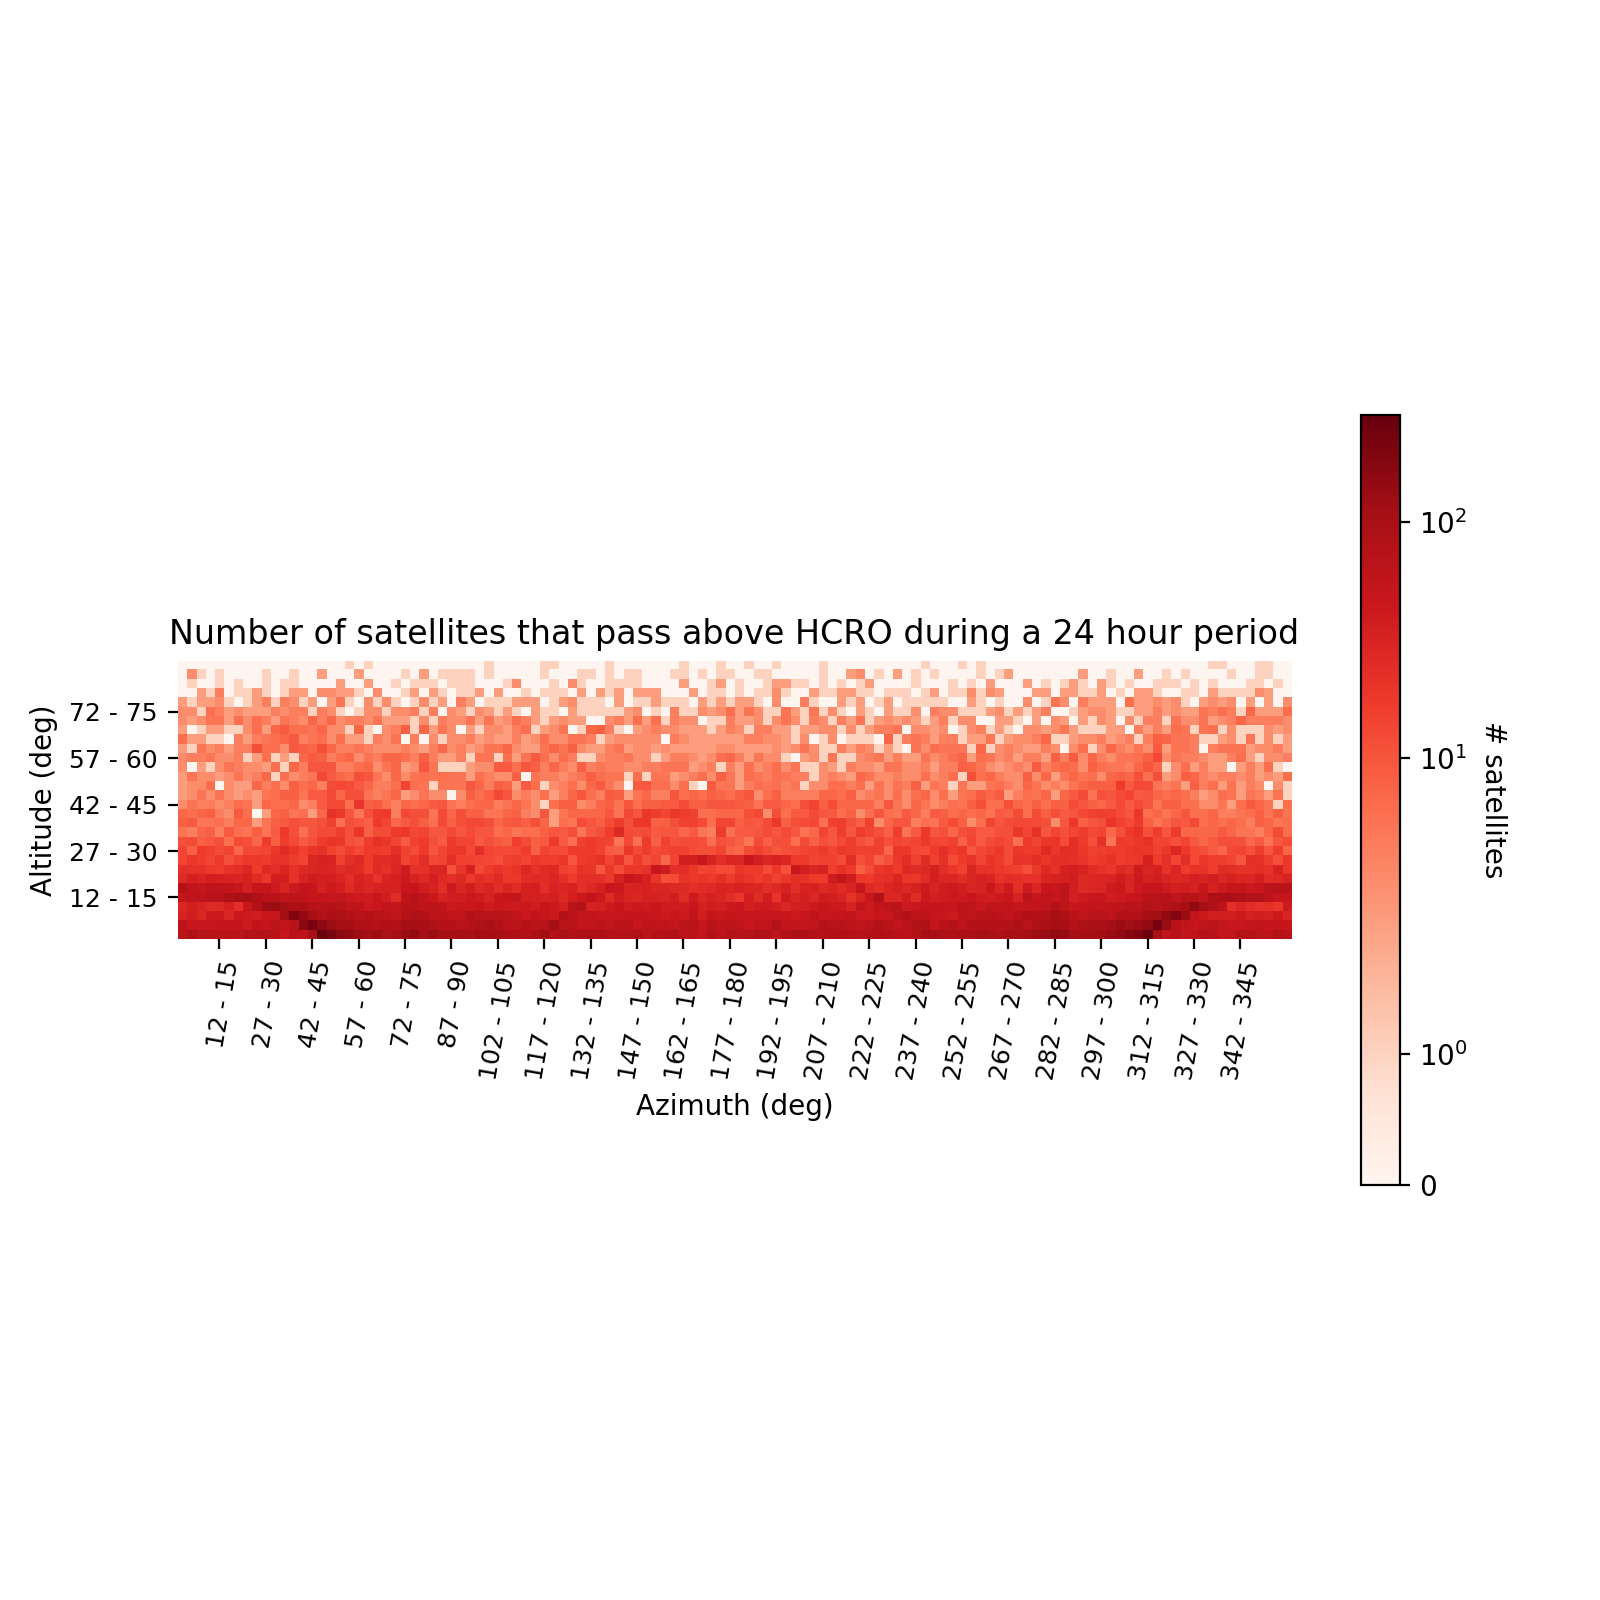

In [44]:
#with correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections3q), alt_range3f, az_range3f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs3, labels=az_range3f_label)
plt.yticks(ticks = alts3, labels = alt_range3f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
plt.savefig('3deg.jpeg')

<IPython.core.display.Javascript object>


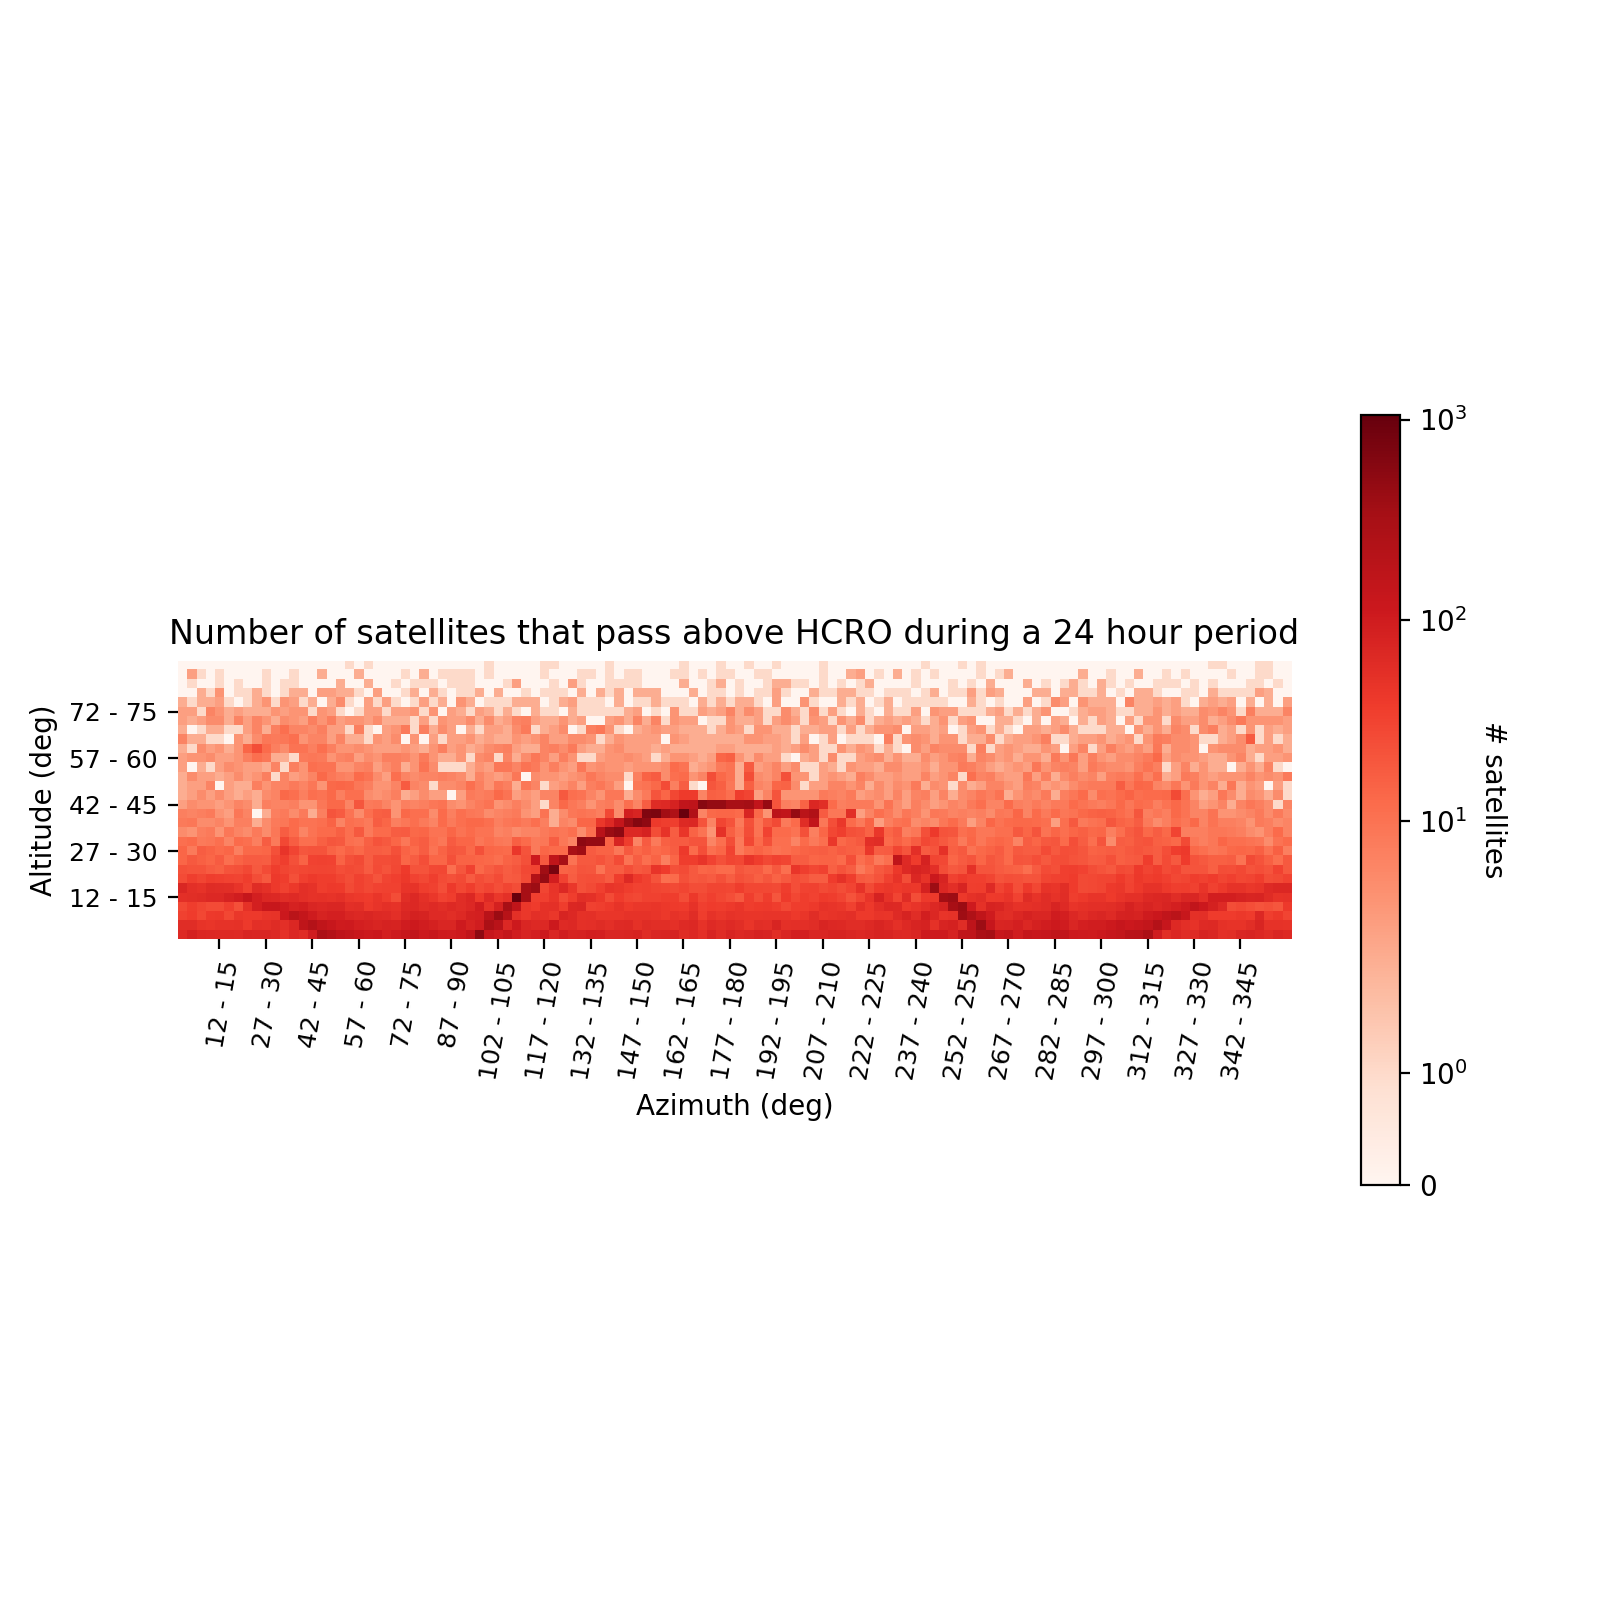

In [45]:
#without correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections3a), alt_range3f, az_range3f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs3, labels=az_range3f_label)
plt.yticks(ticks = alts3, labels = alt_range3f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('5deg.jpeg')

And then for the $90 \times 360$ grid

In [46]:
%%time
qt1 = []
at1 = []
for i in range(len(alt)):
    #print(i)
    for j in range(len(t)):
        if alt[i][j] > 0:
            for h in range(0, 90):
                if (h*1) <= alt[i][j] < ((h+1)*1):
                    for k in range(0, 360):
                        if (k*1) <= az[i][j] < ((k+1)*1):
                            qt1.append((h*360) + k + 1)
                            at1.append((h*360) + k + 1)
        if alt[i][j] <= 0:
            qt1.append(0)
            at1.append(0)
        #if type(altaz_rebinned[i][j]) == int:
         #   qt.append(0)
          #  at.append(0)

CPU times: user 8.58 s, sys: 170 ms, total: 8.75 s
Wall time: 8.52 s


In [47]:
qt1 = np.reshape(qt1, (len(active), len(t)))
at1 = np.reshape(at1, (len(active), len(t)))

In [48]:
for i in range(len(at1)):
    for j in range(len(at1[0])-1):
        if at1[i][j] == at1[i][j+1]:
            qt1[i][j+1] = 0

In [49]:
qt1 = np.reshape(qt1, (len(active) * len(t)))
at1 = np.reshape(at1, len(active) * len(t))

In [50]:
%%time
s1a = []
s1q = []
for i in range(len(at1)):
    s1a.append(f's{at1[i]}')
for i in range(len(qt1)):
    s1q.append(f's{qt1[i]}')


CPU times: user 472 ms, sys: 25.6 ms, total: 497 ms
Wall time: 505 ms


In [51]:
%%time
#About 21 minutes to run
#which section the satellite is in
sections_1a = []
sections_1q = []
for i in range(1, 32401):
    print(i) #Uncomment this if you want to see how much it's run
    if s1a.count(f's{i}') == 0:
        sections_1a.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s1a.count(f's{i}') != 0:
        sections_1a.append(s1a.count(f's{i}'))
    if s1q.count(f's{i}') == 0:
        sections_1q.append(0)
    if s1q.count(f's{i}') != 0:
        sections_1q.append(s1q.count(f's{i}'))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702


5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345


6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985


8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629


10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
1022

11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
1159

12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
1296

14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
1433

15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
1570

16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
1707

18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
1844

19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
1981

21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
2118

22386
22387
22388
22389
22390
22391
22392
22393
22394
22395
22396
22397
22398
22399
22400
22401
22402
22403
22404
22405
22406
22407
22408
22409
22410
22411
22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
2255

23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
2391

25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
2529

26497
26498
26499
26500
26501
26502
26503
26504
26505
26506
26507
26508
26509
26510
26511
26512
26513
26514
26515
26516
26517
26518
26519
26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
2666

27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
2803

29230
29231
29232
29233
29234
29235
29236
29237
29238
29239
29240
29241
29242
29243
29244
29245
29246
29247
29248
29249
29250
29251
29252
29253
29254
29255
29256
29257
29258
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
2939

30600
30601
30602
30603
30604
30605
30606
30607
30608
30609
30610
30611
30612
30613
30614
30615
30616
30617
30618
30619
30620
30621
30622
30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
3076

31971
31972
31973
31974
31975
31976
31977
31978
31979
31980
31981
31982
31983
31984
31985
31986
31987
31988
31989
31990
31991
31992
31993
31994
31995
31996
31997
31998
31999
32000
32001
32002
32003
32004
32005
32006
32007
32008
32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
3213

In [52]:
%%time
alt_range1f = []
az_range1f = []

for i in range(0,90):
    alt_range1f.append(f'{i*1} - {(i+1)*1}')
for i in range(0, 360):
    az_range1f.append(f'{i*1} - {(i + 1)*1}')

CPU times: user 88 µs, sys: 7 µs, total: 95 µs
Wall time: 95.1 µs


In [53]:
az_range1f_label = []
alt_range1f_label = []
azs1 = []
alts1 = []
for i in range(1, int(len(az_range1f)/10)):
    azs1.append((i*10)-1)
    az_range1f_label.append(az_range1f[azs1[-1]])
    
for i in range(1, int(len(alt_range1f)/10)):
    alts1.append((i*10)-1)
    alt_range1f_label.append(alt_range1f[alts1[-1]])

In [54]:
sections1a = np.reshape(sections_1a, (90, 360))
sections1q = np.reshape(sections_1q, (90, 360))
#making it to where it's a 2d array to plot on the heatmap

<IPython.core.display.Javascript object>


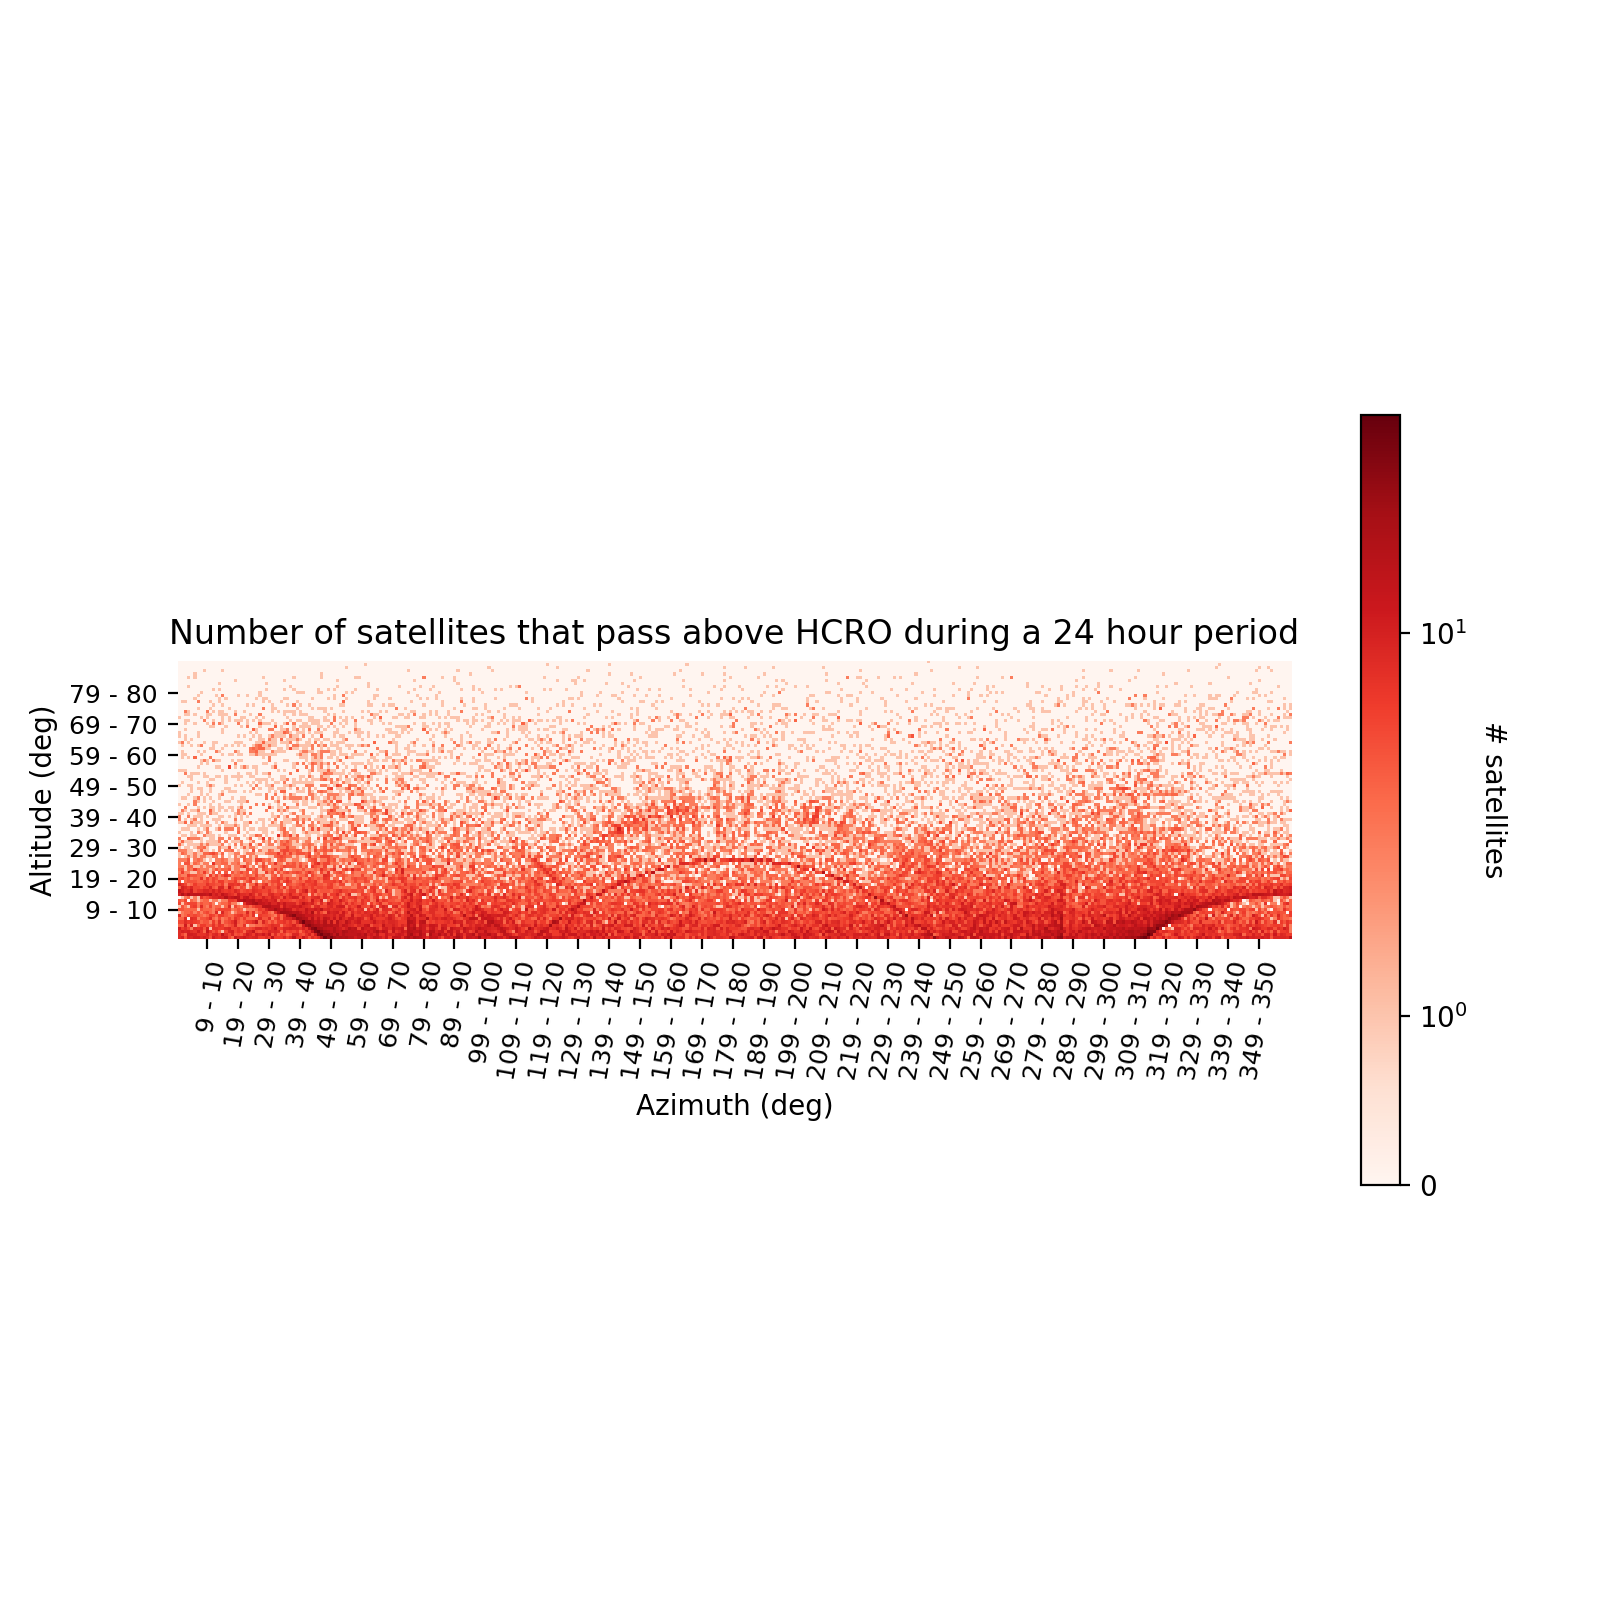

In [55]:
#with correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections1q), alt_range1f, az_range1f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs1, labels=az_range1f_label)
plt.yticks(ticks = alts1, labels = alt_range1f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
plt.savefig('1deg.jpeg')

<IPython.core.display.Javascript object>


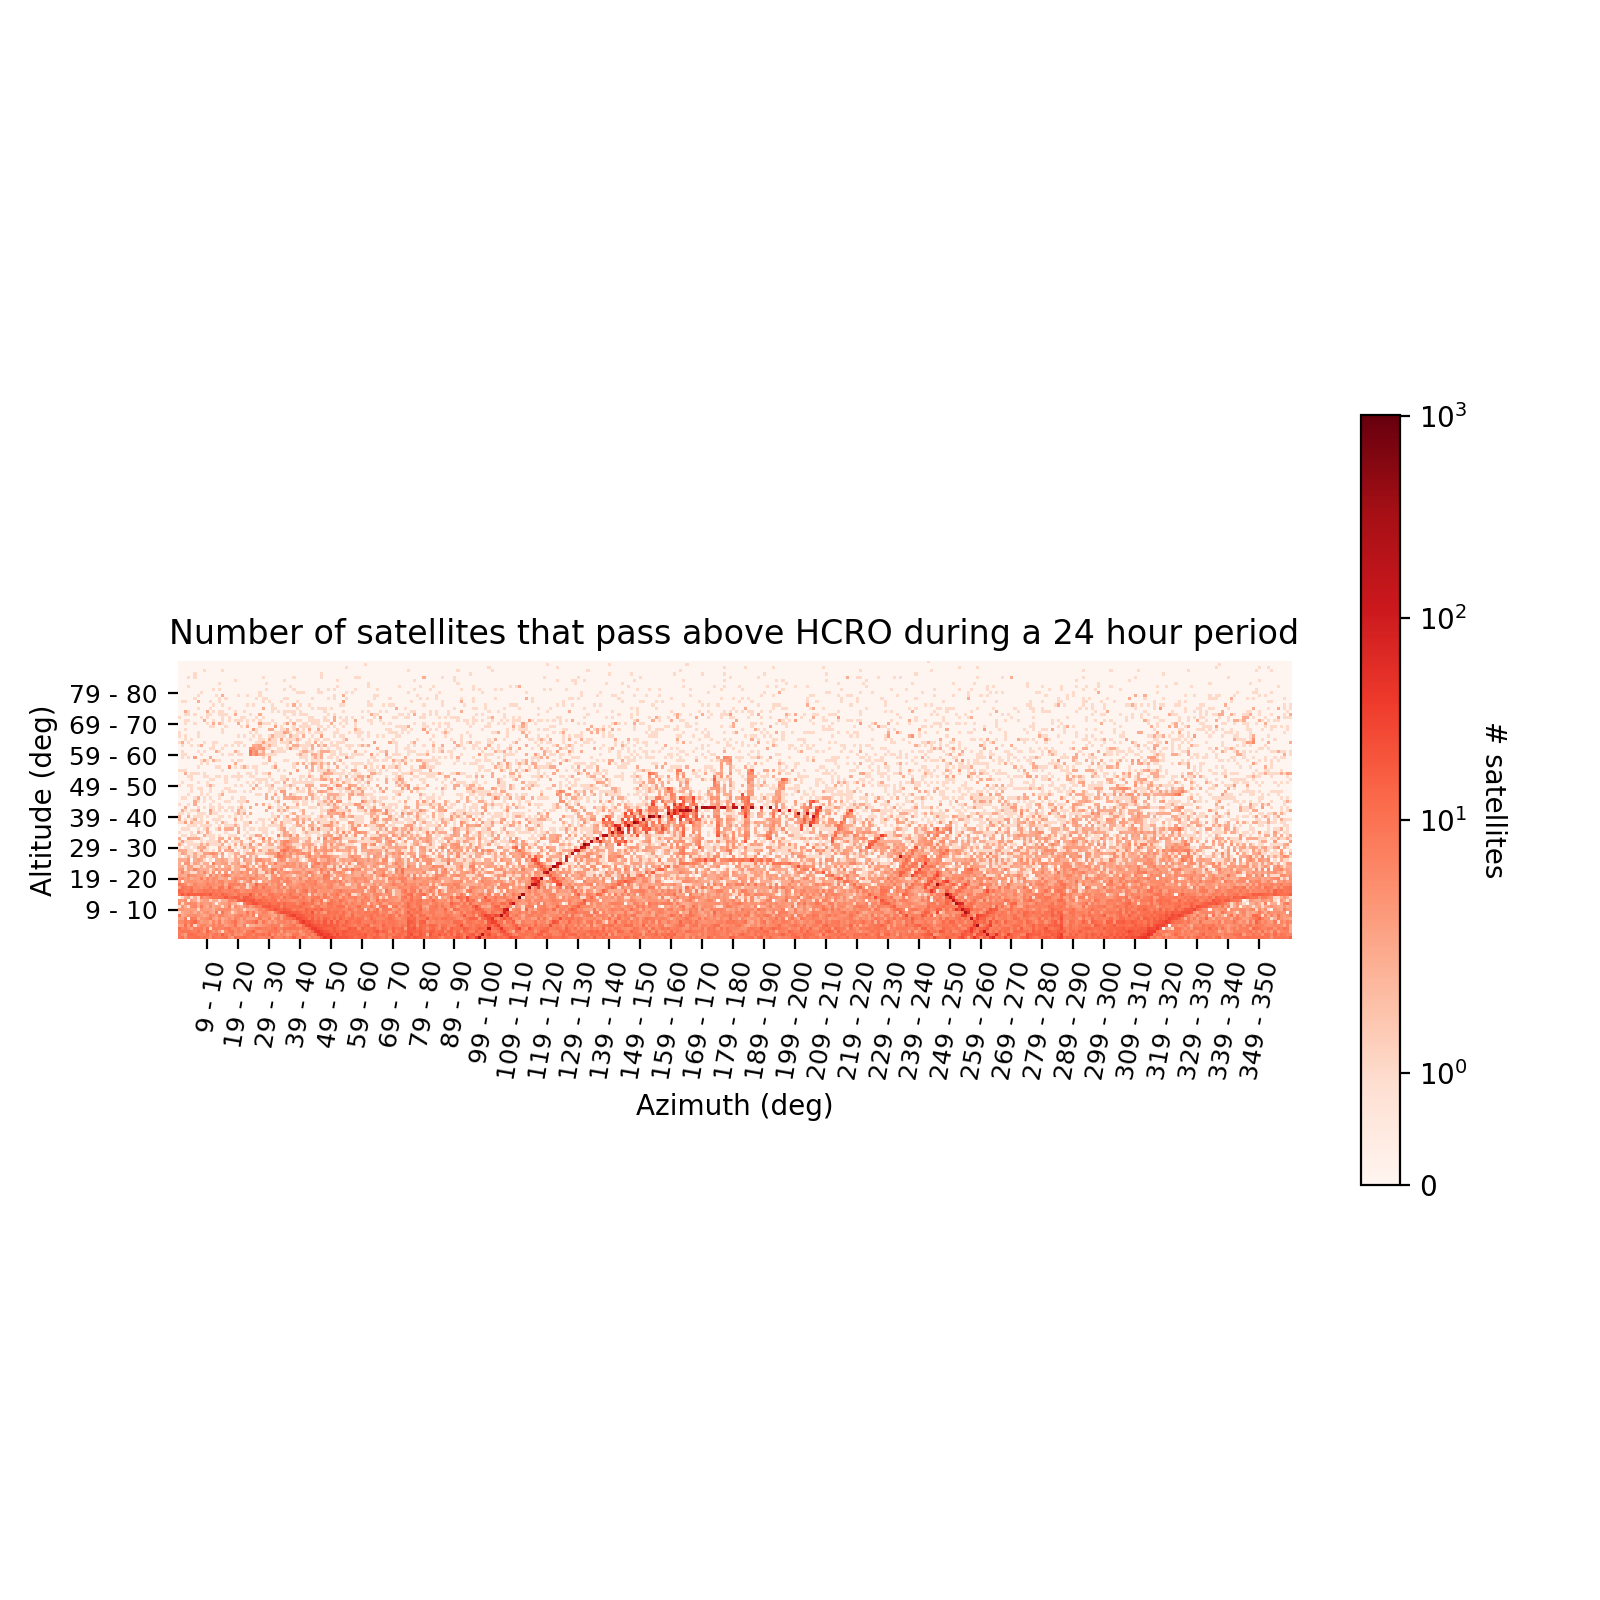

In [56]:
#without correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections1a), alt_range1f, az_range1f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs1, labels=az_range1f_label)
plt.yticks(ticks = alts1, labels = alt_range1f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('5deg.jpeg')